## Description

This notebook is for exploring and building the Monte Carlo architecture for Time Series prediction and risk assessment.

Main idea: Harmonic Stochastic Forecaster for Time Series

In [4]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

from compstat_research.config import PROCESSED_DATA_DIR, MPLSTYLE_DIR

plt.style.use(MPLSTYLE_DIR / "iragca_cmr10.mplstyle")

2025-03-03 08:12:36.498 | INFO     | compstat_research.config:<module>:11 - PROJ_ROOT path is: D:\Documents\3 Production Save Files\1 Cloned repositories\compstat-research


### Loading data

Let's focus on building the architecture by using temperature for now. After we can compare the performance between different variables.

In [5]:
DATA_PATH = PROCESSED_DATA_DIR / "cds" / "era5" / "2m-temperature" / "global"

t2m_daily = pl.read_parquet(DATA_PATH / "era5-2m-temperature-global-daily-avg.parquet")

t2m_monthly = t2m_daily.group_by(["temp_year", "temp_month"]).agg(
    pl.col("avg_temp").mean().alias("t2m_mean")
).with_columns(
    comb=pl.datetime(pl.col("temp_year"), pl.col("temp_month"), pl.lit(1)).alias("date")

)
t2m_yearly = pl.read_parquet(DATA_PATH / "era5-2m-temperature-global-yearly-avg.parquet")

In [6]:
t2m_daily.head(2)

temp_year,temp_month,temp_day,avg_temp
i64,i64,i64,f64
1940,1,2,276.007051
1940,1,3,275.975732


<Axes: xlabel='temp_year', ylabel='avg_temp'>

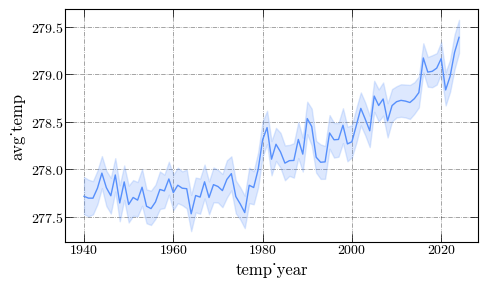

In [7]:
sns.lineplot(data=t2m_daily, x="temp_year", y="avg_temp")

<Axes: xlabel='comb', ylabel='t2m_mean'>

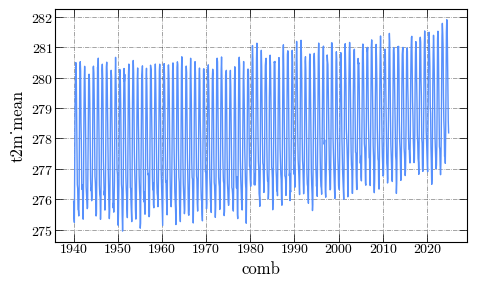

In [8]:
sns.lineplot(data=t2m_monthly, x="comb", y="t2m_mean")

<Axes: xlabel='temp_year', ylabel='avg_temp'>

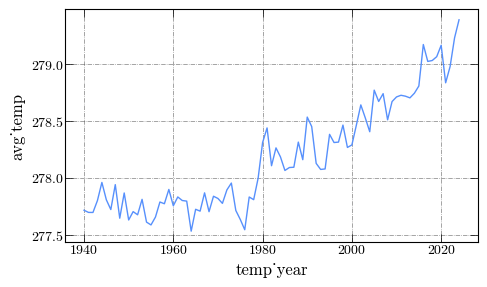

In [9]:
sns.lineplot(data=t2m_yearly, x="temp_year", y="avg_temp")

## Architecture

### Harmonic Stochastic Forecaster v1

It takes an estimator and its prediction, and a random value from a given number of years before the predicted year and take its mean (can be harmonic, geometric or arithmetic). This is done for each predicted year. Each set of predicted years is a single Monte Carlo rollout.

In [ ]:
# Monte Carlo based heuristic


class HarmonicStochasticForecaster_v1:
    """It takes an estimator and its prediction, and a random value
    from a given number of years before the predicted year and take
    its mean (can be harmonic, geometric or arithmetic). This is done
    for each predicted year. Each set of predicted years is a single
    Monte Carlo rollout.
    """

    def __init__(self, dataframe, estimator, series, variable, model_name="HSF-v1"):
        self.dataframe = dataframe
        self.historical_data = dataframe
        self.estimator = estimator
        self.series = series
        self.variable = variable
        self.model_name = model_name

    class MeanFunction:
        @staticmethod
        def harmonic_mean(x, y):
            return 2 / (1 / x + 1 / y)

        @staticmethod
        def geometric_mean(x, y):
            return np.sqrt(x * y)

        @staticmethod
        def arithmetic_mean(x, y):
            return (x + y) / 2

    def _selectyearsbefore(
        self, dataframe: pl.DataFrame, window: int, year: int, time_col: str, value_col: str
    ) -> pl.Series:
        """Returns the distribution of values for a given year and window size before that year.

        Args:
            dataframe (pl.DataFrame): _description_
            window (int): _description_
            year (int): _description_
            time_col (str): _description_
            value_col (str): _description_

        Returns:
            pl.Series: _description_
        """
        return dataframe.filter((pl.col(time_col) < year) & (pl.col(time_col) >= year - window))[
            value_col
        ]

    def run_simulation(
        self,
        year,
        window,
        time_col,
        value_col,
        mean_function=None,
    ):
        if mean_function is None:
            mean_function = self.MeanFunction.harmonic_mean

        random_value = np.random.choice(
            self._selectyearsbefore(self.dataframe, window, year, time_col, value_col)
        )
        prediction = self.estimator.predict([[year]]).flatten()[0]

        return mean_function(random_value, prediction)

    def run_simulations(self, num_simulations, window, start_year, end_year, plot=True):
        simulations = []
        for sim in tqdm(range(num_simulations)):
            iteration_one = []
            for year in range(start_year, end_year):
                iteration_one.append(self.run_simulation(year, window, self.series, self.variable))
            simulations.append(iteration_one)

        if plot:
            self._plot_simulations(simulations, start_year, end_year, window)

        return simulations

    def _plot_simulations(self, simulations, start_year, end_year, window):
        for sim in simulations:
            plt.plot(
                range(start_year, end_year), sim, alpha=0.1, color="orange", label="_nolegend_"
            )

        mean_simulation = np.mean(simulations, axis=0)
        plt.plot(
            range(start_year, end_year), mean_simulation, color="red", label="Simulation Mean"
        )

        sns.lineplot(
            data=self.historical_data, x=self.series, y=self.variable, label="Historical Data"
        )
        plt.title(
            f"{self.model_name} ({start_year}-{end_year}); window={window}; sims={len(simulations)}"
        )
        plt.xlabel("Year")
        plt.ylabel("Temperature (Kelvin)")

100%|██████████| 100/100 [00:06<00:00, 15.22it/s]


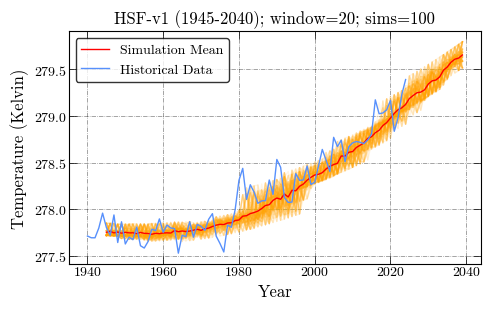

In [108]:
BOUNDARY = 2000

X_train = t2m_yearly.filter(pl.col("temp_year") < BOUNDARY).select("temp_year").to_numpy()
y_train = t2m_yearly.filter(pl.col("temp_year") < BOUNDARY).select("avg_temp").to_numpy()

X_test = t2m_yearly.filter(pl.col("temp_year") >= BOUNDARY).select("temp_year").to_numpy()
y_test = t2m_yearly.filter(pl.col("temp_year") >= BOUNDARY).select("avg_temp").to_numpy()
    
# Create a pipeline (Polynomial Features + Linear Regression)
model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())

# Train the model
model.fit(X_train, y_train)

mc = HarmonicStochasticForecaster_v1(t2m_yearly, model, "temp_year", "avg_temp")

simulations = mc.run_simulations(num_simulations=100, window=20, start_year=1945, end_year=2040)

### HSF v2a

In [ ]:
class HarmonicStochasticForecaster_v2a(HarmonicStochasticForecaster_v1):
    """This model adds the capability to update the dataframe with the new predictions
    and use its distribution for the next year to predict.
    """

    def __init__(self, dataframe, estimator, series, variable, model_name="HSF-v2a"):
        super().__init__(dataframe, estimator, series, variable, model_name)

    def _update_data(self, year, value):
        self.dataframe = pl.concat(
            [
                self.dataframe,
                pl.DataFrame(
                    {
                        self.series: [year],
                        self.variable: [value],
                    }
                ),
            ]
        )


    def run_simulation(
        self,
        year,
        window,
        time_col,
        value_col,
        mean_function=None,
    ):
        if mean_function is None:
            mean_function = self.MeanFunction.harmonic_mean

        random_value = np.random.choice(
            self._selectyearsbefore(self.dataframe, window, year, time_col, value_col)
        )
        prediction = self.estimator.predict([[year]]).flatten()[0]

        self._update_data(year, prediction)

        return mean_function(random_value, prediction)

100%|██████████| 100/100 [18:00<00:00, 10.81s/it]


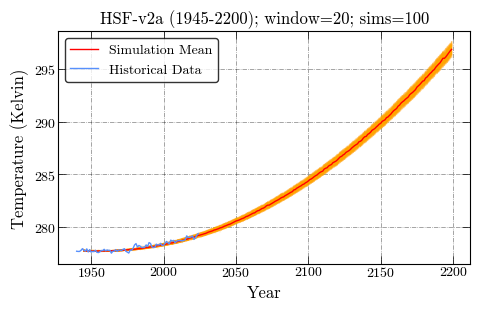

In [110]:
# Create a pipeline (Polynomial Features + Linear Regression)
model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())

# Train the model
model.fit(X_train, y_train)

mcV2 = HarmonicStochasticForecaster_v2a(t2m_yearly, model, "temp_year", "avg_temp")

simulations = mcV2.run_simulations(num_simulations=100, window=20, start_year=1945, end_year=2200)

### HSF v2b

In [ ]:
class HarmonicStochasticForecaster_v2b(HarmonicStochasticForecaster_v2a):

    def __init__(self, dataframe, estimator, series, variable, model_name="HSF-v2b"):
        super().__init__(dataframe, estimator, series, variable, model_name)

    # TODO: Instead of using the distribution from
    # all simulations, use the distribution from the
    # current distribution prediction history only

### HSF v3a

This model not only uses the history of prediction distributions but also refits the estimator to the predicted values for each **rollout**. (Heavy computation)

In [ ]:
class HarmonicStochasticForecaster_v3a(HarmonicStochasticForecaster_v2a):

    def __init__(self, dataframe, estimator, series, variable, model_name="HSF-v3a"):
        super().__init__(dataframe, estimator, series, variable, model_name)

    # TODO: refit to predicted values to each rollout

### HSF v3b

This model not only uses the history of prediction distributions but also refits the estimator to the predicted values for each **predicted year**. (Very heavy computation)

In [ ]:
class HarmonicStochasticForecaster_v3b(HarmonicStochasticForecaster_v2a):

    def __init__(self, dataframe, estimator, series, variable, model_name="HSF-v3b"):
        super().__init__(dataframe, estimator, series, variable, model_name)

    # TODO: refit to predicted values to each predicted year